In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import ndcg_score
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [2]:
train_users = pd.read_csv("/kaggle/input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip")
test_users = pd.read_csv("/kaggle/input/airbnb-recruiting-new-user-bookings/test_users.csv.zip")
labels = train_users['country_destination']


In [3]:
train_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [4]:

test_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [5]:
train_users.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [6]:
test_users.isnull().sum()

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         62096
gender                         0
age                        28876
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked       20
signup_app                     0
first_device_type              0
first_browser                  0
dtype: int64

In [7]:
train_users.describe()

,timestamp_first_active,age,signup_flow
count,2.134510e+05,125461.000000,213451.000000
mean,2.013085e+13,49.668335,3.267387
std,9.253717e+09,155.666612,7.637707
min,2.009032e+13,1.000000,0.000000
25%,2.012123e+13,28.000000,0.000000
50%,2.013091e+13,34.000000,0.000000
75%,2.014031e+13,43.000000,0.000000
max,2.014063e+13,2014.000000,25.000000


In [8]:
print("\nDistribution of the target variable (country_destination):")
print(train_users['country_destination'].value_counts(normalize=True))


Distribution of the target variable (country_destination):
country_destination
NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: proportion, dtype: float64


In [9]:
print("\nUnique values in categorical features:")
categorical_columns = train_users.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"{col}: {train_users[col].nunique()} unique values")


Unique values in categorical features:
id: 213451 unique values
date_account_created: 1634 unique values
date_first_booking: 1976 unique values
gender: 4 unique values
signup_method: 3 unique values
language: 25 unique values
affiliate_channel: 8 unique values
affiliate_provider: 18 unique values
first_affiliate_tracked: 7 unique values
signup_app: 4 unique values
first_device_type: 9 unique values
first_browser: 52 unique values
country_destination: 12 unique values


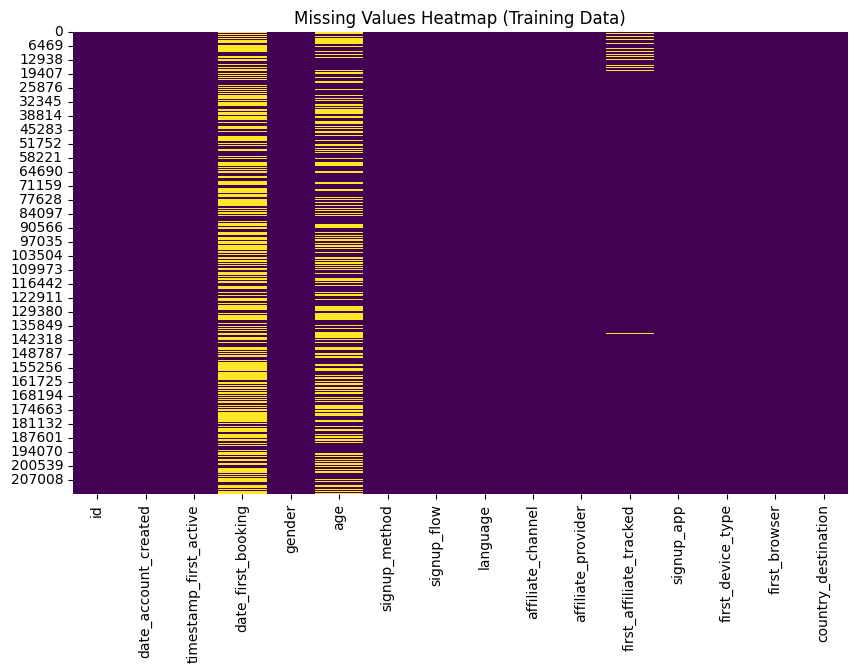

In [10]:

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.heatmap(train_users.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap (Training Data)")
plt.show()

In [11]:
print("\nSample date values for `date_account_created`:")
print(train_users['date_account_created'].head())

print("\nSample date values for `date_first_booking`:")
print(train_users['date_first_booking'].head())


Sample date values for `date_account_created`:
0    2010-06-28
1    2011-05-25
2    2010-09-28
3    2011-12-05
4    2010-09-14
Name: date_account_created, dtype: object

Sample date values for `date_first_booking`:
0           NaN
1           NaN
2    2010-08-02
3    2012-09-08
4    2010-02-18
Name: date_first_booking, dtype: object


In [12]:
print("\nCorrelation matrix for numerical features:")

numerical_columns = train_users.select_dtypes(include=['number'])

correlation_matrix = numerical_columns.corr()

print(correlation_matrix)



Correlation matrix for numerical features:
                        timestamp_first_active       age  signup_flow
timestamp_first_active                1.000000 -0.035961     0.196702
age                                  -0.035961  1.000000    -0.018609
signup_flow                           0.196702 -0.018609     1.000000


In [13]:
def feature_engineering(data):
    if 'date_account_created' in data.columns:
        data['date_account_created'] = pd.to_datetime(data['date_account_created'], errors='coerce')
        data['dac_year'] = data['date_account_created'].dt.year
        data['dac_month'] = data['date_account_created'].dt.month
        data['dac_day'] = data['date_account_created'].dt.day
        data.drop('date_account_created', axis=1, inplace=True)
    
    if 'date_first_booking' in data.columns:
        data['date_first_booking'] = pd.to_datetime(data['date_first_booking'], errors='coerce')
        data['dfb_year'] = data['date_first_booking'].dt.year
        data['dfb_month'] = data['date_first_booking'].dt.month
        data.drop('date_first_booking', axis=1, inplace=True)

    data.fillna(-1, inplace=True)

    for col in data.select_dtypes(include=['object']).columns:
        data[col] = LabelEncoder().fit_transform(data[col].astype(str))

    return data


In [14]:
train_users = feature_engineering(train_users)
test_users = feature_engineering(test_users)

labels = train_users['country_destination']
train_users.drop('country_destination', axis=1, inplace=True)

le = LabelEncoder()
labels_encoded = le.fit_transform(labels)


In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    train_users, labels_encoded, test_size=0.2, random_state=42
)

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    enable_categorical=True  
)
xgb_model.fit(X_train, y_train)

xgb_probs = xgb_model.predict_proba(X_val)

y_val_onehot = to_categorical(y_val, num_classes=xgb_probs.shape[1])
xgb_ndcg = ndcg_score(y_val_onehot, xgb_probs, k=5)
print(f"XGBoost NDCG Score: {xgb_ndcg}")


XGBoost NDCG Score: 0.9274046481808527


In [16]:
def create_nn(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

y_train_onehot = to_categorical(y_train, num_classes=len(le.classes_))
y_val_onehot = to_categorical(y_val, num_classes=len(le.classes_))

nn_model = create_nn(X_train_scaled.shape[1], len(le.classes_))
nn_model.fit(X_train_scaled, y_train_onehot, epochs=20, batch_size=64, validation_data=(X_val_scaled, y_val_onehot))

nn_probs = nn_model.predict(X_val_scaled)

nn_ndcg = ndcg_score(y_val_onehot, nn_probs, k=5)
print(f"Neural Network NDCG Score: {nn_ndcg}")


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2669/2669 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8500 - loss: 0.6053 - val_accuracy: 0.8753 - val_loss: 0.4849
Epoch 2/20
2669/2669 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8761 - loss: 0.4878 - val_accuracy: 0.8753 - val_loss: 0.4855
Epoch 3/20
2669/2669 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8741 - loss: 0.4905 - val_accuracy: 0.8753 - val_loss: 0.4841
Epoch 4/20
2669/2669 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8766 - loss: 0.4805 - val_accuracy: 0.8753 - val_loss: 0.4834
Epoch 5/20
2669/2669 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8766 - loss: 0.4799 - val_accuracy: 0.8753 - val_loss: 0.4835
Epoch 6/20
2669/2669 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8745 - loss: 0.4840 - val_accuracy: 0.8753 - val_loss: 0.4831
Epoch 7/20
2669/2669 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8767 - loss: 0.4794 - val_accuracy: 0.8753 - val_loss: 0.4832
Epoch 8/20
2669/2669 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8758 - loss: 0.4810 - 

In [17]:
ensemble_probs = 0.5 * xgb_probs + 0.5 * nn_probs

ensemble_ndcg = ndcg_score(y_val_onehot, ensemble_probs, k=5)
print(f"Ensemble NDCG Score: {ensemble_ndcg}")


Ensemble NDCG Score: 0.9272853360277029


In [18]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_model = AdaBoostClassifier(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
adaboost_model.fit(X_train, y_train)

adaboost_probs = adaboost_model.predict_proba(X_val)

adaboost_ndcg = ndcg_score(to_categorical(y_val, num_classes=adaboost_probs.shape[1]), adaboost_probs, k=5)
adaboost_accuracy = adaboost_model.score(X_val, y_val)

print(f"AdaBoost NDCG Score: {adaboost_ndcg}")
print(f"AdaBoost Accuracy Score: {adaboost_accuracy}")


AdaBoost NDCG Score: 0.9268324284847957
AdaBoost Accuracy Score: 0.8753132978848001


In [19]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    random_seed=42,
    verbose=0
)
catboost_model.fit(X_train, y_train)

catboost_probs = catboost_model.predict_proba(X_val)

catboost_ndcg = ndcg_score(to_categorical(y_val, num_classes=catboost_probs.shape[1]), catboost_probs, k=5)
catboost_accuracy = catboost_model.score(X_val, y_val)

print(f"CatBoost NDCG Score: {catboost_ndcg}")
print(f"CatBoost Accuracy Score: {catboost_accuracy}")


CatBoost NDCG Score: 0.9273718764939952
CatBoost Accuracy Score: 0.8753132978848001


In [20]:
from lightgbm import LGBMClassifier

lightgbm_model = LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)
lightgbm_model.fit(X_train, y_train)

lightgbm_probs = lightgbm_model.predict_proba(X_val)

lightgbm_ndcg = ndcg_score(to_categorical(y_val, num_classes=lightgbm_probs.shape[1]), lightgbm_probs, k=5)
lightgbm_accuracy = lightgbm_model.score(X_val, y_val)

print(f"LightGBM NDCG Score: {lightgbm_ndcg}")
print(f"LightGBM Accuracy Score: {lightgbm_accuracy}")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 823
[LightGBM] [Info] Number of data points in the train set: 170760, number of used features: 18
[LightGBM] [Info] Start training from score -5.995925
[LightGBM] [Info] Start training from score -4.997892
[LightGBM] [Info] Start training from score -5.299255
[LightGBM] [Info] Start training from score -4.553584
[LightGBM] [Info] Start training from score -3.750720
[LightGBM] [Info] Start training from score -4.537584
[LightGBM] [Info] Start training from score -4.319159
[LightGBM

In [22]:


results = {
    "Model": ["XGBoost", "AdaBoost", "CatBoost", "LightGBM", "Neural Network"],
    "NDCG Score": [xgb_ndcg, adaboost_ndcg, catboost_ndcg, lightgbm_ndcg, nn_ndcg],
}

results_df = pd.DataFrame(results)

results_df = results_df.sort_values(by="NDCG Score", ascending=False)

print("\nModel Performance Comparison (Sorted by NDCG Score):")
print(results_df)



Model Performance Comparison (Sorted by NDCG Score):
            Model  NDCG Score
0         XGBoost    0.927405
2        CatBoost    0.927372
3        LightGBM    0.926855
1        AdaBoost    0.926832
4  Neural Network    0.926820
